In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from IPython.core.pylabtools import figsize
from tqdm import tqdm

In [2]:
import holidays
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# sns.set()

## Read Data

In [5]:
os.listdir('input')

['test.csv', 'train_smoothed.csv', 'train.csv', 'sample_submission.csv']

In [6]:
train_df = pd.read_csv('input/train.csv')
print(train_df.shape)
train_df.head(1)

(136950, 6)


,id,date,country,store,product,num_sold
0,0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63


In [7]:
test_df = pd.read_csv('input/test.csv')
test_df.shape

(27375, 5)

In [8]:
sample_sub = pd.read_csv('input/sample_submission.csv')
print(sample_sub.shape)
sample_sub.head(1)

(27375, 2)


,id,num_sold
0,136950,100


## Get Holidays

In [9]:
train_df.country.unique()

array(['Argentina', 'Canada', 'Estonia', 'Japan', 'Spain'], dtype=object)

In [10]:
start_date = train_df.date.min()
end_date = test_df.date.max()
start_date, end_date

('2017-01-01', '2022-12-31')

In [11]:
def get_national_holidays(country,
                          start_date=start_date,
                          end_date=end_date):
    holidays_days = holidays.CountryHoliday(country)
    date_range = pd.date_range(start_date, end_date)
    return [date for date in date_range
            if date in holidays_days]

In [12]:
common_holidays = pd.DataFrame({
    'ds': pd.to_datetime(['2017-04-16','2017-12-24', '2017-12-25', '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29', '2017-12-30', '2017-12-31',
                          '2018-04-01','2018-12-24', '2018-12-25', '2018-12-26', '2018-12-27', '2018-12-28', '2018-12-29', '2018-12-30', '2018-12-31',
                          '2019-04-21','2019-12-24', '2019-12-25', '2019-12-26', '2019-12-27', '2019-12-28', '2019-12-29', '2019-12-30', '2019-12-31',
                          '2020-04-12','2020-12-24', '2020-12-25', '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29', '2020-12-30', '2020-12-31',
                          '2021-04-04','2021-12-24', '2021-12-25', '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29', '2021-12-30', '2021-12-31',
                          '2022-04-17','2022-12-24', '2022-12-25', '2022-12-26', '2022-12-27', '2022-12-28', '2022-12-29', '2022-12-30', '2022-12-31']),
    'holiday': 'Holiday Season'
    })

In [13]:
country_holiday_dict = {country: pd.DataFrame({
    'holiday': country,
    'ds': pd.to_datetime(get_national_holidays(country))})
                        for country in train_df.country.unique()}

country_holiday_dict['Japan']

,holiday,ds
0,Japan,2017-01-01
1,Japan,2017-01-02
2,Japan,2017-01-09
3,Japan,2017-02-11
4,Japan,2017-03-20
...,...,...
105,Japan,2022-09-19
106,Japan,2022-09-23
107,Japan,2022-10-10
108,Japan,2022-11-03


In [14]:
country_holiday_dict = {country: pd.DataFrame({
    'holiday': country,
    'ds': pd.to_datetime(get_national_holidays(country))})
                        for country in train_df.country.unique()}

country_holiday_dict['Japan']

,holiday,ds
0,Japan,2017-01-01
1,Japan,2017-01-02
2,Japan,2017-01-09
3,Japan,2017-02-11
4,Japan,2017-03-20
...,...,...
105,Japan,2022-09-19
106,Japan,2022-09-23
107,Japan,2022-10-10
108,Japan,2022-11-03


## Data Examination

### Column Check

#### No duplicate `id`

In [15]:
train_df.id.unique().shape, test_df.id.unique().shape

((136950,), (27375,))

#### No new `country` shows up in the test set

In [16]:
train_df.country.unique(), test_df.country.unique()

(array(['Argentina', 'Canada', 'Estonia', 'Japan', 'Spain'], dtype=object),
 array(['Argentina', 'Canada', 'Estonia', 'Japan', 'Spain'], dtype=object))

#### No new `store` shows up in the test set

In [17]:
train_df.store.unique(), test_df.store.unique()

(array(['Kaggle Learn', 'Kaggle Store', 'Kagglazon'], dtype=object),
 array(['Kaggle Learn', 'Kaggle Store', 'Kagglazon'], dtype=object))

#### No new `product` shows up in the test set

In [18]:
train_df['product'].unique(), test_df['product'].unique()

(array(['Using LLMs to Improve Your Coding',
        'Using LLMs to Train More LLMs',
        'Using LLMs to Win Friends and Influence People',
        'Using LLMs to Win More Kaggle Competitions',
        'Using LLMs to Write Better'], dtype=object),
 array(['Using LLMs to Improve Your Coding',
        'Using LLMs to Train More LLMs',
        'Using LLMs to Win Friends and Influence People',
        'Using LLMs to Win More Kaggle Competitions',
        'Using LLMs to Write Better'], dtype=object))

## EDA

In [19]:
cats = ['country', 'store', 'product']
# temp = train_df.copy()
# temp['comb'] = temp[cats].apply(lambda x: '|'.join(list(x)), 
#                                 axis=1)
# temp = temp.pivot(index='date', 
#                   columns='comb',
#                   values='num_sold')
# temp.head()

In [20]:
# figsize(12, 8)

# fig, ax = plt.subplots(1, 1)

# for col in temp.columns:
#     if col.startswith('Argentina|Kagglazon'):
#         sns.lineplot(temp.index,
#                      temp[col],
#                      label=col)
# plt.legend()

# xticklabels = [x.get_text() for x in ax.get_xticklabels()]
# xticks = []
# xlabels = []
# for i, label in enumerate(xticklabels, 0):
#     if label.endswith('-01'):
#         xlabels.append(label)
#         xticks.append(i)
        
# _ = ax.set_xticks(xticks, xlabels, rotation=90)

In [21]:
temp = train_df.copy()
temp_gb = temp.groupby(['date', 'country'])[['num_sold']].sum().reset_index()
temp_gb = temp_gb.pivot(index='date', columns='country', values='num_sold')
temp_gb.head()

country,Argentina,Canada,Estonia,Japan,Spain
date,,,,,
2017-01-01,2011,6134,2772,5274,3895
2017-01-02,1487,5081,2062,3983,2950
2017-01-03,1448,5049,1984,3742,2816
2017-01-04,1357,4710,1985,3784,2680
2017-01-05,1316,4629,1920,3609,2609


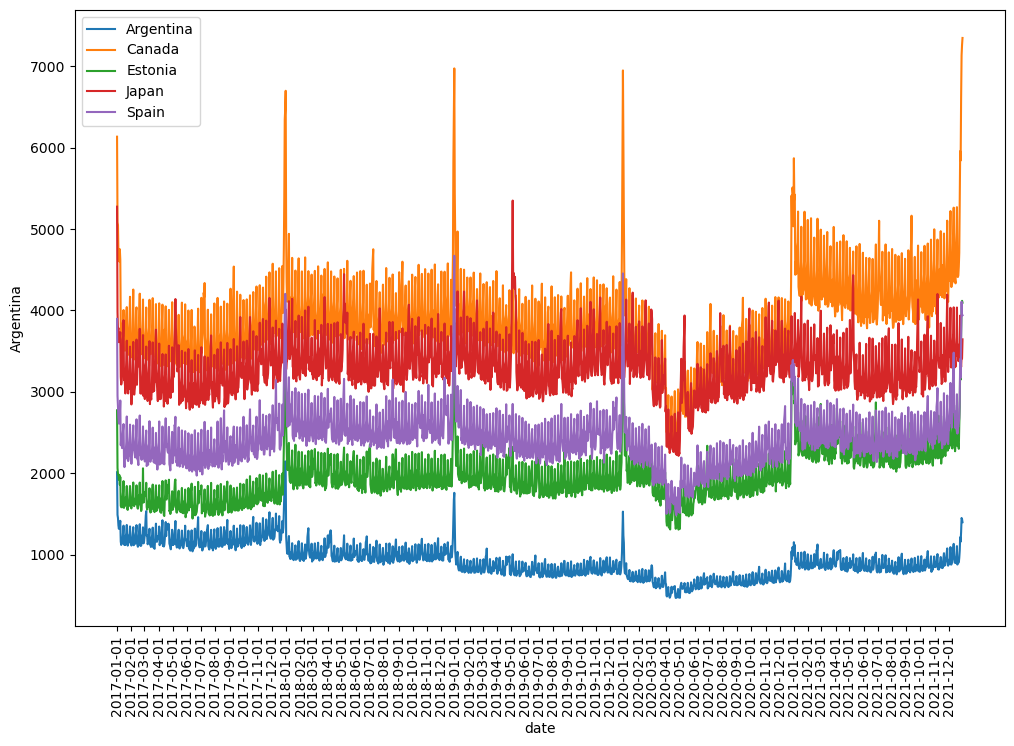

In [22]:
figsize(12, 8)

fig, ax = plt.subplots(1, 1)

for country in temp_gb.columns:
    sns.lineplot(temp_gb.index, temp_gb[country], label=country)
plt.legend()

xticklabels = [x.get_text() for x in ax.get_xticklabels()]
xticks = []
xlabels = []
for i, label in enumerate(xticklabels, 0):
    if label.endswith('-01'):
        xlabels.append(label)
        xticks.append(i)
        
_ = ax.set_xticks(xticks, xlabels, rotation=90)

## Modeling

In [23]:
def pre_process(df, cats=cats):
    df['comb'] = df[cats].apply(lambda x: '|'.join(list(x)), axis=1)
    df['y'] = df['num_sold']
    df['ds'] = df['date']
    groups_by_comb = df.groupby('comb')
    print(len(groups_by_comb.groups.keys()))
    
    return df, groups_by_comb

In [24]:
train_df, groups_by_comb = pre_process(train_df)

75


### Define Function

In [25]:
def train_and_forecast(group, country, 
                       country_holiday_dict=country_holiday_dict):
    # Train
    m = Prophet(yearly_seasonality=True,
                weekly_seasonality=True,
                holidays=country_holiday_dict[country])
    m.fit(group)
    
    # Predict
    future = m.make_future_dataframe(periods=365)
    forecast = m.predict(future)
    forecast['comb'] = group['comb'].iloc[0]
    
    # Return 
    return m, forecast

In [26]:
preds = pd.DataFrame()
models = []
forecasts = []

for comb in train_df.comb.unique():
    country = comb.split('|')[0]
    group = groups_by_comb.get_group(comb)
    m, forecast = train_and_forecast(group, country)
    preds = pd.concat((preds, forecast[['ds', 'comb', 'yhat', 'yhat_upper', 'yhat_lower']]))
    models.append(m)
    forecasts.append(forecast)
    
preds.head()

16:21:51 - cmdstanpy - INFO - Chain [1] start processing
16:21:51 - cmdstanpy - INFO - Chain [1] done processing
16:21:52 - cmdstanpy - INFO - Chain [1] start processing
16:21:52 - cmdstanpy - INFO - Chain [1] done processing
16:21:53 - cmdstanpy - INFO - Chain [1] start processing
16:21:53 - cmdstanpy - INFO - Chain [1] done processing
16:21:54 - cmdstanpy - INFO - Chain [1] start processing
16:21:55 - cmdstanpy - INFO - Chain [1] done processing
16:21:55 - cmdstanpy - INFO - Chain [1] start processing
16:21:56 - cmdstanpy - INFO - Chain [1] done processing
16:21:56 - cmdstanpy - INFO - Chain [1] start processing
16:21:57 - cmdstanpy - INFO - Chain [1] done processing
16:21:57 - cmdstanpy - INFO - Chain [1] start processing
16:21:58 - cmdstanpy - INFO - Chain [1] done processing
16:21:58 - cmdstanpy - INFO - Chain [1] start processing
16:21:59 - cmdstanpy - INFO - Chain [1] done processing
16:21:59 - cmdstanpy - INFO - Chain [1] start processing
16:22:00 - cmdstanpy - INFO - Chain [1]

16:23:13 - cmdstanpy - INFO - Chain [1] done processing
16:23:13 - cmdstanpy - INFO - Chain [1] start processing
16:23:14 - cmdstanpy - INFO - Chain [1] done processing
16:23:14 - cmdstanpy - INFO - Chain [1] start processing
16:23:15 - cmdstanpy - INFO - Chain [1] done processing


,ds,comb,yhat,yhat_upper,yhat_lower
0,2017-01-01,Argentina|Kaggle Learn|Using LLMs to Improve Y...,46.864478,50.461205,43.130087
1,2017-01-02,Argentina|Kaggle Learn|Using LLMs to Improve Y...,41.322718,45.052473,37.881944
2,2017-01-03,Argentina|Kaggle Learn|Using LLMs to Improve Y...,40.795094,44.277285,37.262230
3,2017-01-04,Argentina|Kaggle Learn|Using LLMs to Improve Y...,40.548180,44.365933,36.962552
4,2017-01-05,Argentina|Kaggle Learn|Using LLMs to Improve Y...,40.289227,43.752726,36.640774


## Evaluation

In [27]:
def get_metrics(m):
    m_cv = cross_validation(model=m, 
                            initial='1460 days',
                            period='30 days',
                            horizon='365 days')
    pm = performance_metrics(m_cv)
    return pm[pm['horizon'] == '365 days'][['rmse', 'smape']].values[0]

In [28]:
metrics = [get_metrics(m) for m in tqdm(models)]

  0%|                                                    | 0/75 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

16:23:16 - cmdstanpy - INFO - Chain [1] start processing
16:23:16 - cmdstanpy - INFO - Chain [1] done processing
  1%|▌                                           | 1/75 [00:01<01:44,  1.41s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:23:17 - cmdstanpy - INFO - Chain [1] start processing
16:23:17 - cmdstanpy - INFO - Chain [1] done processing
  3%|█▏                                          | 2/75 [00:02<01:41,  1.39s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:23:18 - cmdstanpy - INFO - Chain [1] start processing
16:23:18 - cmdstanpy - INFO - Chain [1] done processing
  4%|█▊                                          | 3/75 [00:04<01:50,  1.53s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:23:20 - cmdstanpy - INFO - Chain [1] start processing
16:23:20 - cmdstanpy - INFO - Chain [1] done processing
  5%|██▎                                         | 4/75 [00:05<01:46,  1.51s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:23:21 - cmdstanpy - INFO - Chain [1] start processing
16:23:22 - cmdstanpy - INFO - Chain [1] done processing
  7%|██▉                                         | 5/75 [00:07<01:49,  1.56s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:23:23 - cmdstanpy - INFO - Chain [1] start processing
16:23:23 - cmdstanpy - INFO - Chain [1] done processing
  8%|███▌                                        | 6/75 [00:08<01:43,  1.50s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:23:25 - cmdstanpy - INFO - Chain [1] start processing
16:23:25 - cmdstanpy - INFO - Chain [1] done processing
  9%|████                                        | 7/75 [00:10<01:37,  1.43s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:23:26 - cmdstanpy - INFO - Chain [1] start processing
16:23:26 - cmdstanpy - INFO - Chain [1] done processing
 11%|████▋                                       | 8/75 [00:11<01:31,  1.37s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:23:27 - cmdstanpy - INFO - Chain [1] start processing
16:23:27 - cmdstanpy - INFO - Chain [1] done processing
 12%|█████▎                                      | 9/75 [00:12<01:27,  1.33s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:23:28 - cmdstanpy - INFO - Chain [1] start processing
16:23:29 - cmdstanpy - INFO - Chain [1] done processing
 13%|█████▋                                     | 10/75 [00:14<01:27,  1.35s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:23:30 - cmdstanpy - INFO - Chain [1] start processing
16:23:30 - cmdstanpy - INFO - Chain [1] done processing
 15%|██████▎                                    | 11/75 [00:15<01:24,  1.31s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:23:31 - cmdstanpy - INFO - Chain [1] start processing
16:23:31 - cmdstanpy - INFO - Chain [1] done processing
 16%|██████▉                                    | 12/75 [00:16<01:23,  1.33s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:23:32 - cmdstanpy - INFO - Chain [1] start processing
16:23:32 - cmdstanpy - INFO - Chain [1] done processing
 17%|███████▍                                   | 13/75 [00:18<01:26,  1.39s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:23:34 - cmdstanpy - INFO - Chain [1] start processing
16:23:34 - cmdstanpy - INFO - Chain [1] done processing
 19%|████████                                   | 14/75 [00:19<01:24,  1.38s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:23:35 - cmdstanpy - INFO - Chain [1] start processing
16:23:35 - cmdstanpy - INFO - Chain [1] done processing
 20%|████████▌                                  | 15/75 [00:21<01:27,  1.46s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:23:37 - cmdstanpy - INFO - Chain [1] start processing
16:23:37 - cmdstanpy - INFO - Chain [1] done processing
 21%|█████████▏                                 | 16/75 [00:23<01:40,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:23:39 - cmdstanpy - INFO - Chain [1] start processing
16:23:40 - cmdstanpy - INFO - Chain [1] done processing
 23%|█████████▋                                 | 17/75 [00:25<01:37,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:23:41 - cmdstanpy - INFO - Chain [1] start processing
16:23:41 - cmdstanpy - INFO - Chain [1] done processing
 24%|██████████▎                                | 18/75 [00:26<01:33,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:23:42 - cmdstanpy - INFO - Chain [1] start processing
16:23:43 - cmdstanpy - INFO - Chain [1] done processing
 25%|██████████▉                                | 19/75 [00:28<01:29,  1.60s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:23:44 - cmdstanpy - INFO - Chain [1] start processing
16:23:44 - cmdstanpy - INFO - Chain [1] done processing
 27%|███████████▍                               | 20/75 [00:29<01:27,  1.59s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:23:45 - cmdstanpy - INFO - Chain [1] start processing
16:23:46 - cmdstanpy - INFO - Chain [1] done processing
 28%|████████████                               | 21/75 [00:31<01:26,  1.60s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:23:47 - cmdstanpy - INFO - Chain [1] start processing
16:23:47 - cmdstanpy - INFO - Chain [1] done processing
 29%|████████████▌                              | 22/75 [00:33<01:27,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:23:49 - cmdstanpy - INFO - Chain [1] start processing
16:23:49 - cmdstanpy - INFO - Chain [1] done processing
 31%|█████████████▏                             | 23/75 [00:34<01:22,  1.60s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:23:50 - cmdstanpy - INFO - Chain [1] start processing
16:23:50 - cmdstanpy - INFO - Chain [1] done processing
 32%|█████████████▊                             | 24/75 [00:36<01:18,  1.53s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:23:52 - cmdstanpy - INFO - Chain [1] start processing
16:23:52 - cmdstanpy - INFO - Chain [1] done processing
 33%|██████████████▎                            | 25/75 [00:37<01:14,  1.48s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:23:53 - cmdstanpy - INFO - Chain [1] start processing
16:23:53 - cmdstanpy - INFO - Chain [1] done processing
 35%|██████████████▉                            | 26/75 [00:38<01:12,  1.49s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:23:54 - cmdstanpy - INFO - Chain [1] start processing
16:23:55 - cmdstanpy - INFO - Chain [1] done processing
 36%|███████████████▍                           | 27/75 [00:40<01:10,  1.46s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:23:56 - cmdstanpy - INFO - Chain [1] start processing
16:23:56 - cmdstanpy - INFO - Chain [1] done processing
 37%|████████████████                           | 28/75 [00:41<01:10,  1.51s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:23:57 - cmdstanpy - INFO - Chain [1] start processing
16:23:58 - cmdstanpy - INFO - Chain [1] done processing
 39%|████████████████▋                          | 29/75 [00:43<01:09,  1.52s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:23:59 - cmdstanpy - INFO - Chain [1] start processing
16:23:59 - cmdstanpy - INFO - Chain [1] done processing
 40%|█████████████████▏                         | 30/75 [00:44<01:07,  1.50s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:24:00 - cmdstanpy - INFO - Chain [1] start processing
16:24:01 - cmdstanpy - INFO - Chain [1] done processing
 41%|█████████████████▊                         | 31/75 [00:46<01:05,  1.48s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:24:02 - cmdstanpy - INFO - Chain [1] start processing
16:24:02 - cmdstanpy - INFO - Chain [1] done processing
 43%|██████████████████▎                        | 32/75 [00:47<01:01,  1.44s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:24:03 - cmdstanpy - INFO - Chain [1] start processing
16:24:03 - cmdstanpy - INFO - Chain [1] done processing
 44%|██████████████████▉                        | 33/75 [00:49<01:00,  1.44s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:24:05 - cmdstanpy - INFO - Chain [1] start processing
16:24:05 - cmdstanpy - INFO - Chain [1] done processing
 45%|███████████████████▍                       | 34/75 [00:50<01:02,  1.52s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:24:06 - cmdstanpy - INFO - Chain [1] start processing
16:24:07 - cmdstanpy - INFO - Chain [1] done processing
 47%|████████████████████                       | 35/75 [00:52<01:02,  1.56s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:24:08 - cmdstanpy - INFO - Chain [1] start processing
16:24:08 - cmdstanpy - INFO - Chain [1] done processing
 48%|████████████████████▋                      | 36/75 [00:53<00:59,  1.53s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:24:09 - cmdstanpy - INFO - Chain [1] start processing
16:24:10 - cmdstanpy - INFO - Chain [1] done processing
 49%|█████████████████████▏                     | 37/75 [00:55<00:57,  1.52s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:24:11 - cmdstanpy - INFO - Chain [1] start processing
16:24:11 - cmdstanpy - INFO - Chain [1] done processing
 51%|█████████████████████▊                     | 38/75 [00:57<00:56,  1.52s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:24:13 - cmdstanpy - INFO - Chain [1] start processing
16:24:13 - cmdstanpy - INFO - Chain [1] done processing
 52%|██████████████████████▎                    | 39/75 [00:58<00:54,  1.52s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:24:14 - cmdstanpy - INFO - Chain [1] start processing
16:24:14 - cmdstanpy - INFO - Chain [1] done processing
 53%|██████████████████████▉                    | 40/75 [01:00<00:53,  1.52s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:24:16 - cmdstanpy - INFO - Chain [1] start processing
16:24:16 - cmdstanpy - INFO - Chain [1] done processing
 55%|███████████████████████▌                   | 41/75 [01:01<00:50,  1.50s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:24:17 - cmdstanpy - INFO - Chain [1] start processing
16:24:17 - cmdstanpy - INFO - Chain [1] done processing
 56%|████████████████████████                   | 42/75 [01:02<00:48,  1.48s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:24:18 - cmdstanpy - INFO - Chain [1] start processing
16:24:19 - cmdstanpy - INFO - Chain [1] done processing
 57%|████████████████████████▋                  | 43/75 [01:04<00:48,  1.51s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:24:20 - cmdstanpy - INFO - Chain [1] start processing
16:24:20 - cmdstanpy - INFO - Chain [1] done processing
 59%|█████████████████████████▏                 | 44/75 [01:06<00:46,  1.51s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:24:22 - cmdstanpy - INFO - Chain [1] start processing
16:24:22 - cmdstanpy - INFO - Chain [1] done processing
 60%|█████████████████████████▊                 | 45/75 [01:07<00:44,  1.50s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:24:23 - cmdstanpy - INFO - Chain [1] start processing
16:24:23 - cmdstanpy - INFO - Chain [1] done processing
 61%|██████████████████████████▎                | 46/75 [01:09<00:44,  1.52s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:24:25 - cmdstanpy - INFO - Chain [1] start processing
16:24:25 - cmdstanpy - INFO - Chain [1] done processing
 63%|██████████████████████████▉                | 47/75 [01:10<00:42,  1.50s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:24:26 - cmdstanpy - INFO - Chain [1] start processing
16:24:26 - cmdstanpy - INFO - Chain [1] done processing
 64%|███████████████████████████▌               | 48/75 [01:11<00:39,  1.46s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:24:27 - cmdstanpy - INFO - Chain [1] start processing
16:24:28 - cmdstanpy - INFO - Chain [1] done processing
 65%|████████████████████████████               | 49/75 [01:13<00:38,  1.47s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:24:29 - cmdstanpy - INFO - Chain [1] start processing
16:24:29 - cmdstanpy - INFO - Chain [1] done processing
 67%|████████████████████████████▋              | 50/75 [01:14<00:36,  1.48s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:24:30 - cmdstanpy - INFO - Chain [1] start processing
16:24:31 - cmdstanpy - INFO - Chain [1] done processing
 68%|█████████████████████████████▏             | 51/75 [01:16<00:35,  1.47s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:24:32 - cmdstanpy - INFO - Chain [1] start processing
16:24:32 - cmdstanpy - INFO - Chain [1] done processing
 69%|█████████████████████████████▊             | 52/75 [01:17<00:33,  1.45s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:24:33 - cmdstanpy - INFO - Chain [1] start processing
16:24:33 - cmdstanpy - INFO - Chain [1] done processing
 71%|██████████████████████████████▍            | 53/75 [01:19<00:31,  1.45s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:24:35 - cmdstanpy - INFO - Chain [1] start processing
16:24:35 - cmdstanpy - INFO - Chain [1] done processing
 72%|██████████████████████████████▉            | 54/75 [01:20<00:31,  1.50s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:24:36 - cmdstanpy - INFO - Chain [1] start processing
16:24:37 - cmdstanpy - INFO - Chain [1] done processing
 73%|███████████████████████████████▌           | 55/75 [01:22<00:30,  1.50s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:24:38 - cmdstanpy - INFO - Chain [1] start processing
16:24:38 - cmdstanpy - INFO - Chain [1] done processing
 75%|████████████████████████████████           | 56/75 [01:23<00:28,  1.52s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:24:39 - cmdstanpy - INFO - Chain [1] start processing
16:24:40 - cmdstanpy - INFO - Chain [1] done processing
 76%|████████████████████████████████▋          | 57/75 [01:25<00:26,  1.50s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:24:41 - cmdstanpy - INFO - Chain [1] start processing
16:24:41 - cmdstanpy - INFO - Chain [1] done processing
 77%|█████████████████████████████████▎         | 58/75 [01:26<00:25,  1.48s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:24:42 - cmdstanpy - INFO - Chain [1] start processing
16:24:42 - cmdstanpy - INFO - Chain [1] done processing
 79%|█████████████████████████████████▊         | 59/75 [01:28<00:23,  1.47s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:24:44 - cmdstanpy - INFO - Chain [1] start processing
16:24:44 - cmdstanpy - INFO - Chain [1] done processing
 80%|██████████████████████████████████▍        | 60/75 [01:29<00:22,  1.49s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:24:45 - cmdstanpy - INFO - Chain [1] start processing
16:24:46 - cmdstanpy - INFO - Chain [1] done processing
 81%|██████████████████████████████████▉        | 61/75 [01:31<00:21,  1.51s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:24:47 - cmdstanpy - INFO - Chain [1] start processing
16:24:47 - cmdstanpy - INFO - Chain [1] done processing
 83%|███████████████████████████████████▌       | 62/75 [01:32<00:19,  1.53s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:24:48 - cmdstanpy - INFO - Chain [1] start processing
16:24:49 - cmdstanpy - INFO - Chain [1] done processing
 84%|████████████████████████████████████       | 63/75 [01:34<00:18,  1.53s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:24:50 - cmdstanpy - INFO - Chain [1] start processing
16:24:50 - cmdstanpy - INFO - Chain [1] done processing
 85%|████████████████████████████████████▋      | 64/75 [01:35<00:17,  1.55s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:24:52 - cmdstanpy - INFO - Chain [1] start processing
16:24:52 - cmdstanpy - INFO - Chain [1] done processing
 87%|█████████████████████████████████████▎     | 65/75 [01:37<00:15,  1.54s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:24:53 - cmdstanpy - INFO - Chain [1] start processing
16:24:53 - cmdstanpy - INFO - Chain [1] done processing
 88%|█████████████████████████████████████▊     | 66/75 [01:39<00:13,  1.53s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:24:55 - cmdstanpy - INFO - Chain [1] start processing
16:24:55 - cmdstanpy - INFO - Chain [1] done processing
 89%|██████████████████████████████████████▍    | 67/75 [01:40<00:12,  1.50s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:24:56 - cmdstanpy - INFO - Chain [1] start processing
16:24:56 - cmdstanpy - INFO - Chain [1] done processing
 91%|██████████████████████████████████████▉    | 68/75 [01:41<00:10,  1.48s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:24:57 - cmdstanpy - INFO - Chain [1] start processing
16:24:58 - cmdstanpy - INFO - Chain [1] done processing
 92%|███████████████████████████████████████▌   | 69/75 [01:43<00:08,  1.47s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:24:59 - cmdstanpy - INFO - Chain [1] start processing
16:24:59 - cmdstanpy - INFO - Chain [1] done processing
 93%|████████████████████████████████████████▏  | 70/75 [01:45<00:07,  1.53s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:25:01 - cmdstanpy - INFO - Chain [1] start processing
16:25:01 - cmdstanpy - INFO - Chain [1] done processing
 95%|████████████████████████████████████████▋  | 71/75 [01:46<00:06,  1.50s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:25:02 - cmdstanpy - INFO - Chain [1] start processing
16:25:02 - cmdstanpy - INFO - Chain [1] done processing
 96%|█████████████████████████████████████████▎ | 72/75 [01:47<00:04,  1.49s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:25:03 - cmdstanpy - INFO - Chain [1] start processing
16:25:04 - cmdstanpy - INFO - Chain [1] done processing
 97%|█████████████████████████████████████████▊ | 73/75 [01:49<00:02,  1.48s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:25:05 - cmdstanpy - INFO - Chain [1] start processing
16:25:05 - cmdstanpy - INFO - Chain [1] done processing
 99%|██████████████████████████████████████████▍| 74/75 [01:50<00:01,  1.47s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

16:25:06 - cmdstanpy - INFO - Chain [1] start processing
16:25:07 - cmdstanpy - INFO - Chain [1] done processing
100%|███████████████████████████████████████████| 75/75 [01:52<00:00,  1.50s/it]


In [29]:
def build_res_df(metrics, train_df=train_df):
    res_data = [[comb, metrics[i][1] * 100, metrics[i][0]]
                for i, comb in enumerate(train_df.comb.unique(), 0)]
    res_df = pd.DataFrame(res_data, columns=['comb', 'smape', 'rmse'])
    res_df['country'] = res_df['comb'].apply(lambda x: x.split('|')[0])
    res_df['store'] = res_df['comb'].apply(lambda x: x.split('|')[1])
    res_df['product'] = res_df['comb'].apply(lambda x: x.split('|')[2])
    return res_df.drop('comb', axis=1)

In [30]:
res_df = build_res_df(metrics)
res_df

,smape,rmse,country,store,product
0,52.387468,14.733597,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding
1,39.813766,11.819976,Argentina,Kaggle Learn,Using LLMs to Train More LLMs
2,48.009363,1.979861,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People
3,38.970883,10.859635,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions
4,17.575866,5.174242,Argentina,Kaggle Learn,Using LLMs to Write Better
...,...,...,...,...,...
70,12.079059,91.457515,Spain,Kagglazon,Using LLMs to Improve Your Coding
71,13.456625,92.130464,Spain,Kagglazon,Using LLMs to Train More LLMs
72,13.720889,14.625256,Spain,Kagglazon,Using LLMs to Win Friends and Influence People
73,10.183455,62.244948,Spain,Kagglazon,Using LLMs to Win More Kaggle Competitions


In [31]:
res_df.groupby('country')['smape'].mean()

country
Argentina    39.003409
Canada       17.227483
Estonia      12.235743
Japan         6.085267
Spain        12.480795
Name: smape, dtype: float64

In [32]:
res_df.groupby('store')['smape'].mean()

store
Kagglazon       17.185978
Kaggle Learn    17.762763
Kaggle Store    17.270877
Name: smape, dtype: float64

In [33]:
res_df.groupby('product')['smape'].mean()

product
Using LLMs to Improve Your Coding                 20.960978
Using LLMs to Train More LLMs                     18.727027
Using LLMs to Win Friends and Influence People    19.620973
Using LLMs to Win More Kaggle Competitions        16.416592
Using LLMs to Write Better                        11.307125
Name: smape, dtype: float64

In [34]:
print(f'Average SMAPE: {np.mean([m[1] for m in metrics]) * 100:.5f}')
print(f'Average RMSE: {np.mean([m[0] for m in metrics]):.2f}')

Average SMAPE: 17.40654
Average RMSE: 35.15


## Submission

In [35]:
subs = preds[preds.ds > train_df.ds.max()]
subs = subs.rename(columns={'ds': 'date',
                            'yhat': 'num_sold'})
subs['date'] = subs['date'].apply(str).apply(lambda x: x.split(' ')[0])
subs.head(1)

,date,comb,num_sold,yhat_upper,yhat_lower
1826,2022-01-01,Argentina|Kaggle Learn|Using LLMs to Improve Y...,36.449051,40.180478,33.10047


In [36]:
test_df['comb'] = test_df[cats].apply(lambda x: '|'.join(list(x)), 
                                      axis=1)
test_df.head(1)

,id,date,country,store,product,comb
0,136950,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,Argentina|Kaggle Learn|Using LLMs to Improve Y...


In [37]:
test_df = test_df.merge(subs, how='left', on=['date', 'comb'])
test_df.head(1)

,id,date,country,store,product,comb,num_sold,yhat_upper,yhat_lower
0,136950,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,Argentina|Kaggle Learn|Using LLMs to Improve Y...,36.449051,40.180478,33.10047


In [38]:
# multi_dict = {'Canada': .58 * 1.5,
#               'Japan': .76 * 1.5,
#               'Spain': 1 * 1.5,
#               'Estonia': 1.08 * 1.5,
#               'Argentina': 2.82 * 1.5}

In [39]:
# def multipliers(test_df, multi_dict=multi_dict):
#     for country in test_df.country.unique():
#         test_df['num_sold'][test_df.country == country] *= multi_dict[country]
#     return test_df['num_sold']

In [40]:
# test_df["num_sold"] = np.round(multipliers(test_df))

In [39]:
test_df[['id', 'comb', 'num_sold']].to_csv('subs/season_holidays_subs/1_covid.csv', index=False)